<a href="https://colab.research.google.com/github/IraDionisio/CSCI-166-DQN-Final-Project/blob/main/DoubleDQNBeamRider.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test 3 --- Final Test for 06.11.2025

In [1]:
!pip install gymnasium[atari,accept-rom-license]
!pip install autorom
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 6.4 MB/s eta 0:00:00


In [2]:
!AutoROM --accept-license

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.12/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/adventure.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/air_raid.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/alien.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/amidar.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/assault.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/asterix.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/asteroids.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/atlantis.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/atlantis2.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/backgammon.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/bank_heist.bin
Inst

# Install the Gym

In [3]:
import ale_py
import gymnasium as gym

# Configure the model save drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
save_dir = "/content/drive/MyDrive/PUBLIC/Models"
os.makedirs(save_dir, exist_ok=True)

# Now Model

In [6]:
from dataclasses import dataclass
import argparse
import time
from datetime import datetime
import numpy as np
import collections
import typing as tt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.tensorboard.writer import SummaryWriter

In [7]:
#dqn_model
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        size = self.conv(torch.zeros(1, *input_shape)).size()[-1]
        self.fc = nn.Sequential(
            nn.Linear(size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    def forward(self, x: torch.ByteTensor):
        x = x.float() / 255.0
        return self.fc(self.conv(x))

In [8]:
#wrappers

from gymnasium import spaces
from stable_baselines3.common import atari_wrappers


class ImageToPyTorch(gym.ObservationWrapper):
    """
    ImageToPyTorch: Reorders image dimensions from (H, W, C) to (C, H, W)
    for compatibility with PyTorch convolutional layers.
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        obs = self.observation_space
        assert isinstance(obs, gym.spaces.Box)
        assert len(obs.shape) == 3
        new_shape = (obs.shape[-1], obs.shape[0], obs.shape[1])
        self.observation_space = gym.spaces.Box(
            low=obs.low.min(), high=obs.high.max(),
            shape=new_shape, dtype=obs.dtype)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class BufferWrapper(gym.ObservationWrapper):
    """
    BufferWrapper: Maintains a rolling window of the last `n_steps` frames
    to give the agent a sense of temporal context.
    """
    def __init__(self, env, n_steps):
        super(BufferWrapper, self).__init__(env)
        obs = env.observation_space
        assert isinstance(obs, spaces.Box)
        new_obs = gym.spaces.Box(
            obs.low.repeat(n_steps, axis=0), obs.high.repeat(n_steps, axis=0),
            dtype=obs.dtype)
        self.observation_space = new_obs
        self.buffer = collections.deque(maxlen=n_steps)

    def reset(self, *, seed: tt.Optional[int] = None, options: tt.Optional[dict[str, tt.Any]] = None):
        for _ in range(self.buffer.maxlen):
            self.buffer.append(np.zeros_like(self.env.observation_space.low))
        obs, extra = self.env.reset()
        return self.observation(obs), extra

    def observation(self, observation: np.ndarray) -> np.ndarray:
        self.buffer.append(observation)
        return np.concatenate(self.buffer)


def make_env(env_name: str, render_mode=None, **kwargs):
    print(f"Creating environment {env_name}")
    env = gym.make(env_name, render_mode=render_mode, **kwargs)
    env = atari_wrappers.AtariWrapper(env, clip_reward=False, noop_max=0)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, n_steps=N_STEPS)
    return env

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [9]:
DEFAULT_ENV_NAME = "ALE/BeamRider-v5"
MEAN_REWARD_BOUND = 500 # Default value, will be overridden by fast training config

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 10000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000
N_STEPS = 4 # for frame-stacking

SAVE_EPSILON = 0.5  # Only save if at least this much better
EPSILON_DECAY_LAST_FRAME = 150000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01

# Tuple of tensors returned from a sampled minibatch in replay buffer
State = np.ndarray
Action = int
BatchTensors = tt.Tuple[
    torch.ByteTensor,           # current state
    torch.LongTensor,           # actions
    torch.Tensor,               # rewards
    torch.BoolTensor,           # done || trunc
    torch.ByteTensor            # next state
]

In [10]:
# ⚙️ Fast Training Config for Quick Test Run
MEAN_REWARD_BOUND = 500 # Changed to allow for more meaningful training
REPLAY_START_SIZE = 1000
EPSILON_DECAY_LAST_FRAME = 10_000
SYNC_TARGET_FRAMES = 500

# REPLAY_SIZE = 5000  # optional
# BATCH_SIZE = 16     # optional

In [11]:
import os
from pathlib import Path

# Define directories
save_dir_drive = "/content/drive/MyDrive/PUBLIC/Models"
save_dir_local = "saved_models"

# Create both directories if they don't exist
os.makedirs(save_dir_drive, exist_ok=True)
os.makedirs(save_dir_local, exist_ok=True)

# Safe model filename
env_name = DEFAULT_ENV_NAME
safe_env_name = env_name.replace("/", "_")

In [12]:
@dataclass
class Experience:
    state: State
    action: Action
    reward: float
    done_trunc: bool
    new_state: State


class ExperienceBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience: Experience):
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> tt.List[Experience]:
        indices = np.random.choice(len(self), batch_size, replace=False)
        return [self.buffer[idx] for idx in indices]

In [13]:
class Agent:
    def __init__(self, env: gym.Env, exp_buffer: ExperienceBuffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self.state: tt.Optional[np.ndarray] = None
        self._reset()

    def _reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net: DQN, device: torch.device,
                  epsilon: float = 0.0) -> tt.Optional[float]:
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_v = torch.as_tensor(self.state).to(device)
            state_v.unsqueeze_(0)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, is_tr, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(
            state=self.state, action=action, reward=float(reward),
            done_trunc=is_done or is_tr, new_state=new_state
        )
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done or is_tr:
            done_reward = self.total_reward
            self._reset()
        return done_reward

In [14]:
def batch_to_tensors(batch: tt.List[Experience], device: torch.device) -> BatchTensors:
    states, actions, rewards, dones, new_state = [], [], [], [], []
    for e in batch:
        states.append(e.state)
        actions.append(e.action)
        rewards.append(e.reward)
        dones.append(e.done_trunc)
        new_state.append(e.new_state)
    states_t = torch.as_tensor(np.asarray(states))
    actions_t = torch.LongTensor(actions)
    rewards_t = torch.FloatTensor(rewards)
    dones_t = torch.BoolTensor(dones)
    new_states_t = torch.as_tensor(np.asarray(new_state))
    return states_t.to(device), actions_t.to(device), rewards_t.to(device), \
           dones_t.to(device),  new_states_t.to(device)

In [15]:
def calc_loss(batch: tt.List[Experience], net: DQN, tgt_net: DQN,
              device: torch.device) -> torch.Tensor:
    states_t, actions_t, rewards_t, dones_t, new_states_t = batch_to_tensors(batch, device)

    state_action_values = net(states_t).gather(
        1, actions_t.unsqueeze(-1)
    ).squeeze(-1)
    with torch.no_grad():
        # Double DQN change: Use online net to select action, target net to evaluate Q-value
        next_state_actions = net(new_states_t).argmax(dim=1)
        next_state_values = tgt_net(new_states_t).gather(
            1, next_state_actions.unsqueeze(-1)
        ).squeeze(-1)
        next_state_values[dones_t] = 0.0
        next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * GAMMA + rewards_t
    return nn.MSELoss()(state_action_values, expected_state_action_values)

In [16]:
model_comment = f"lr{LEARNING_RATE}_gamma{GAMMA}_epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_bs{BATCH_SIZE}_sync{SYNC_TARGET_FRAMES}_fs{N_STEPS}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = make_env(env_name)
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
writer = SummaryWriter(comment=f"-{env_name}-{model_comment}")
print(net)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_m_reward = None

hparams = {
    'learning_rate': LEARNING_RATE,
    'gamma': GAMMA,
    'epsilon_start': EPSILON_START,
    'epsilon_final': EPSILON_FINAL,
    'epsilon_decay_last_frame': EPSILON_DECAY_LAST_FRAME,
    'replay_size': REPLAY_SIZE,
    'replay_start_size': REPLAY_START_SIZE,
    'batch_size': BATCH_SIZE,
    'sync_target_frames': SYNC_TARGET_FRAMES,
    'frame_stack': N_STEPS,
    'optimizer': 'Adam',
    'mean_reward_bound': MEAN_REWARD_BOUND
}

start_time = time.time()
while True:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

    reward = agent.play_step(net, device, epsilon)
    if reward is not None:
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        elapsed = time.time() - start_time  # in seconds
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(total_rewards[-100:])
        print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, "
             f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")
        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", m_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)
        if best_m_reward is None or m_reward > best_m_reward + SAVE_EPSILON:
            # print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, "
            #    f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")
            timestamp = datetime.now().strftime("%Y%m%d-%H%M")
            model_filename = f"{safe_env_name}-best_{int(m_reward)}-{timestamp}-{model_comment}.dat"

            # Save to both paths
            model_path_drive = os.path.join(save_dir_drive, model_filename)
            model_path_local = os.path.join(save_dir_local, model_filename)

            torch.save(net.state_dict(), model_path_drive)
            torch.save(net.state_dict(), model_path_local)

            print(f"💾 Model saved to:\n - Google Drive: {model_path_drive}\n - Local:        {model_path_local}")
            if best_m_reward is not None:
                print(f"Best reward updated {best_m_reward:.3f} -> {m_reward:.3f}")
            best_m_reward = m_reward

            writer.add_hparams(hparams, {'metric/mean_reward': m_reward}, global_step=frame_idx)

        if m_reward > MEAN_REWARD_BOUND:
            print("Solved in %d frames!" % frame_idx)
            break
    if len(buffer) < REPLAY_START_SIZE:
        continue
    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device)
    loss_t.backward()
    optimizer.step()
env.close()
writer.close()

Creating environment ALE/BeamRider-v5
DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=9, bias=True)
  )
)
156: done 1 games, reward 132.000, eps 0.98, speed 202.90 f/s, time 0.0 min
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_BeamRider-v5-best_132-20251201-0319-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4.dat
 - Local:        saved_models/ALE_BeamRider-v5-best_132-20251201-0319-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4.dat


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


240: done 2 games, reward 110.000, eps 0.98, speed 158.14 f/s, time 0.0 min
291: done 3 games, reward 88.000, eps 0.97, speed 164.29 f/s, time 0.0 min
401: done 4 games, reward 165.000, eps 0.96, speed 181.54 f/s, time 0.0 min
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_BeamRider-v5-best_165-20251201-0319-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4.dat
 - Local:        saved_models/ALE_BeamRider-v5-best_165-20251201-0319-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4.dat
Best reward updated 132.000 -> 165.000
529: done 5 games, reward 132.000, eps 0.95, speed 165.58 f/s, time 0.0 min
787: done 6 games, reward 154.000, eps 0.92, speed 210.63 f/s, time 0.1 min
881: done 7 games, reward 150.857, eps 0.91, speed 265.72 f/s, time 0.1 min
985: done 8 games, reward 143.000, eps 0.90, speed 280.35 f/s, time 0.1 min
1151: done 9 games, reward 132.000, eps 0.88, speed 11.00 f/s, time 0.3 min
1306: done 10 games, reward 132.000, eps 0.87, speed 8

KeyboardInterrupt: 

In [ ]:
from gymnasium.wrappers import RecordVideo

VIDEO_DIR_LOCAL = 'videos'
VIDEO_DIR_DRIVE = f"{save_dir}/videos"

print(f"VIDEO_DIR_LOCAL: {VIDEO_DIR_LOCAL}")
print(f"VIDEO_DIR_DRIVE: {VIDEO_DIR_DRIVE}")

In [ ]:
import os
os.makedirs(VIDEO_DIR_LOCAL, exist_ok=True)
os.makedirs(VIDEO_DIR_DRIVE, exist_ok=True)

print(f"Created local video directory: {VIDEO_DIR_LOCAL}")
print(f"Created Google Drive video directory: {VIDEO_DIR_DRIVE}")

In [ ]:
def save_video_for_model(current_net, device, tag, num_episodes=1):
    def make_video_env(env_name, video_dir):
        # Create a new environment for video recording
        env = gym.make(env_name, render_mode='rgb_array')
        env = atari_wrappers.AtariWrapper(env, clip_reward=False, noop_max=0)
        env = ImageToPyTorch(env)
        env = BufferWrapper(env, n_steps=N_STEPS)
        # Wrap with RecordVideo
        env = RecordVideo(env, video_folder=video_dir, name_prefix=tag, episode_trigger=lambda x: True)
        return env

    # Create environments for local and Drive video saving
    video_env_local = make_video_env(DEFAULT_ENV_NAME, VIDEO_DIR_LOCAL)
    video_env_drive = make_video_env(DEFAULT_ENV_NAME, VIDEO_DIR_DRIVE)

    # Load the current network's state dictionary into a new model for evaluation
    eval_net = DQN(video_env_local.observation_space.shape, video_env_local.action_space.n).to(device)
    eval_net.load_state_dict(current_net.state_dict())
    eval_net.eval() # Set to evaluation mode

    print(f"Recording {num_episodes} episodes for tag: {tag}...")
    for i in range(num_episodes):
        obs, _ = video_env_local.reset()
        video_env_drive.reset() # Reset the drive env too for synchronization in recording logic

        done = False
        total_reward = 0
        while not done:
            state_v = torch.as_tensor(obs).to(device)
            state_v.unsqueeze_(0)
            q_vals_v = eval_net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

            # Step both environments to ensure consistent video recording
            obs, reward, is_done, is_tr, _ = video_env_local.step(action)
            _, _, _, _, _ = video_env_drive.step(action)

            total_reward += reward
            done = is_done or is_tr

        print(f"  Episode {i+1} finished with reward: {total_reward}")

    video_env_local.close()
    video_env_drive.close()
    print(f"Video recording for tag '{tag}' complete.")

In [ ]:
VIDEO_FPS = 60
MIN_VIDEO_DURATION_SECONDS = 10
MAX_VIDEO_DURATION_SECONDS = 30
VIDEO_RESOLUTION = (640, 480)

print(f"VIDEO_FPS: {VIDEO_FPS}")
print(f"MIN_VIDEO_DURATION_SECONDS: {MIN_VIDEO_DURATION_SECONDS}")
print(f"MAX_VIDEO_DURATION_SECONDS: {MAX_VIDEO_DURATION_SECONDS}")
print(f"VIDEO_RESOLUTION: {VIDEO_RESOLUTION}")

In [ ]:
def save_video_for_model(current_net, device, tag, num_episodes=1):
    def make_video_env(env_name, video_dir):
        # Wrap with RecordVideo first to ensure it captures the full environment output
        env = gym.make(env_name, render_mode='rgb_array')
        env = RecordVideo(
            env,
            video_folder=video_dir,
            name_prefix=tag,
            episode_trigger=lambda x: True,
            fps=VIDEO_FPS,
            # Apply the desired video resolution
            disable_logger=True # disable logger to prevent unnecessary output
        )
        # Then apply other wrappers like AtariWrapper
        env = atari_wrappers.AtariWrapper(env, clip_reward=False, noop_max=0)
        env = ImageToPyTorch(env)
        env = BufferWrapper(env, n_steps=N_STEPS)
        return env

    # Calculate max frames based on FPS and max duration
    MAX_FRAMES_PER_VIDEO = VIDEO_FPS * MAX_VIDEO_DURATION_SECONDS

    # Create environments for local and Drive video saving
    video_env_local = make_video_env(DEFAULT_ENV_NAME, VIDEO_DIR_LOCAL)
    video_env_drive = make_video_env(DEFAULT_ENV_NAME, VIDEO_DIR_DRIVE)

    # Load the current network's state dictionary into a new model for evaluation
    eval_net = DQN(video_env_local.observation_space.shape, video_env_local.action_space.n).to(device)
    eval_net.load_state_dict(current_net.state_dict())
    eval_net.eval() # Set to evaluation mode

    print(f"Recording {num_episodes} episodes for tag: {tag}...")
    for i in range(num_episodes):
        obs, _ = video_env_local.reset()
        video_env_drive.reset() # Reset the drive env too for synchronization in recording logic

        done = False
        total_reward = 0
        frame_counter = 0
        while not done and frame_counter < MAX_FRAMES_PER_VIDEO:
            state_v = torch.as_tensor(obs).to(device)
            state_v.unsqueeze_(0)
            q_vals_v = eval_net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

            # Step both environments to ensure consistent video recording
            obs, reward, is_done, is_tr, _ = video_env_local.step(action)
            _, _, _, _, _ = video_env_drive.step(action)

            total_reward += reward
            done = is_done or is_tr
            frame_counter += 1

        print(f"  Episode {i+1} finished with reward: {total_reward} (frames: {frame_counter})")

    video_env_local.close()
    video_env_drive.close()
    print(f"Video recording for tag '{tag}' complete.")

In [ ]:
EARLY_VIDEO_FRAME_THRESHOLD = 5000
TRAINED_VIDEO_REWARD_THRESHOLD = 100
VIDEO_RECORD_EPISODES = 2

print(f"EARLY_VIDEO_FRAME_THRESHOLD: {EARLY_VIDEO_FRAME_THRESHOLD}")
print(f"TRAINED_VIDEO_REWARD_THRESHOLD: {TRAINED_VIDEO_REWARD_THRESHOLD}")
print(f"VIDEO_RECORD_EPISODES: {VIDEO_RECORD_EPISODES}")

In [ ]:
model_comment = f"lr{LEARNING_RATE}_gamma{GAMMA}_epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_bs{BATCH_SIZE}_sync{SYNC_TARGET_FRAMES}_fs{N_STEPS}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = make_env(env_name)
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
writer = SummaryWriter(comment=f"-{env_name}-{model_comment}")
print(net)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_m_reward = None

hparams = {
    'learning_rate': LEARNING_RATE,
    'gamma': GAMMA,
    'epsilon_start': EPSILON_START,
    'epsilon_final': EPSILON_FINAL,
    'epsilon_decay_last_frame': EPSILON_DECAY_LAST_FRAME,
    'replay_size': REPLAY_SIZE,
    'replay_start_size': REPLAY_START_SIZE,
    'batch_size': BATCH_SIZE,
    'sync_target_frames': SYNC_TARGET_FRAMES,
    'frame_stack': N_STEPS,
    'optimizer': 'Adam',
    'mean_reward_bound': MEAN_REWARD_BOUND
}

# Flags to ensure video is recorded only once per trigger point
early_video_recorded = False
trained_video_recorded = False

start_time = time.time()
while True:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

    reward = agent.play_step(net, device, epsilon)
    if reward is not None:
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        elapsed = time.time() - start_time  # in seconds
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(total_rewards[-100:])
        print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, "
             f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")
        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", m_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)

        # --- Video Recording Triggers ---
        # 1. Early video recording
        if not early_video_recorded and frame_idx >= EARLY_VIDEO_FRAME_THRESHOLD:
            print(f"\n>>> Triggering early video recording at frame_idx {frame_idx} <<<")
            save_video_for_model(net, device, tag=f"early_training_f{frame_idx}", num_episodes=VIDEO_RECORD_EPISODES)
            early_video_recorded = True

        # 2. When the model starts performing well
        if not trained_video_recorded and m_reward >= TRAINED_VIDEO_REWARD_THRESHOLD:
            print(f"\n>>> Triggering trained video recording (m_reward {m_reward:.3f}) at frame_idx {frame_idx} <<<")
            save_video_for_model(net, device, tag=f"trained_reward_{int(m_reward)}_f{frame_idx}", num_episodes=VIDEO_RECORD_EPISODES)
            trained_video_recorded = True
        # --- End Video Recording Triggers ---

        if best_m_reward is None or m_reward > best_m_reward + SAVE_EPSILON:
            timestamp = datetime.now().strftime("%Y%m%d-%H%M")
            model_filename = f"{safe_env_name}-best_{int(m_reward)}-{timestamp}-{model_comment}.dat"

            model_path_drive = os.path.join(save_dir_drive, model_filename)
            model_path_local = os.path.join(save_dir_local, model_filename)

            torch.save(net.state_dict(), model_path_drive)
            torch.save(net.state_dict(), model_path_local)

            print(f"💾 Model saved to:\n - Google Drive: {model_path_drive}\n - Local:        {model_path_local}")
            if best_m_reward is not None:
                print(f"Best reward updated {best_m_reward:.3f} -> {m_reward:.3f}")
            best_m_reward = m_reward

            writer.add_hparams(hparams, {'metric/mean_reward': m_reward}, global_step=frame_idx)

        if m_reward >= MEAN_REWARD_BOUND:
            print("Solved in %d frames!" % frame_idx)
            # --- Video Recording Triggers ---
            print(f"\n>>> Triggering final solved video recording (m_reward {m_reward:.3f}) at frame_idx {frame_idx} <<<")
            save_video_for_model(net, device, tag=f"solved_reward_{int(m_reward)}_f{frame_idx}", num_episodes=VIDEO_RECORD_EPISODES)
            # --- End Video Recording Triggers ---
            break

    if len(buffer) < REPLAY_START_SIZE:
        continue
    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device)
    loss_t.backward()
    optimizer.step()
env.close()
writer.close()

In [ ]:
model_comment = f"lr{LEARNING_RATE}_gamma{GAMMA}_epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_bs{BATCH_SIZE}_sync{SYNC_TARGET_FRAMES}_fs{N_STEPS}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = make_env(env_name)
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
writer = SummaryWriter(comment=f"-{env_name}-{model_comment}")
print(net)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_m_reward = None

hparams = {
    'learning_rate': LEARNING_RATE,
    'gamma': GAMMA,
    'epsilon_start': EPSILON_START,
    'epsilon_final': EPSILON_FINAL,
    'epsilon_decay_last_frame': EPSILON_DECAY_LAST_FRAME,
    'replay_size': REPLAY_SIZE,
    'replay_start_size': REPLAY_START_SIZE,
    'batch_size': BATCH_SIZE,
    'sync_target_frames': SYNC_TARGET_FRAMES,
    'frame_stack': N_STEPS,
    'optimizer': 'Adam',
    'mean_reward_bound': MEAN_REWARD_BOUND
}

# Flags to ensure video is recorded only once per trigger point
early_video_recorded = False
trained_video_recorded = False

start_time = time.time()
while True:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

    reward = agent.play_step(net, device, epsilon)
    if reward is not None:
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        elapsed = time.time() - start_time  # in seconds
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(total_rewards[-100:])
        print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, "
             f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")
        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", m_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)

        # --- Video Recording Triggers ---
        # 1. Early video recording
        if not early_video_recorded and frame_idx >= EARLY_VIDEO_FRAME_THRESHOLD:
            print(f"\n>>> Triggering early video recording at frame_idx {frame_idx} <<<")
            save_video_for_model(net, device, tag=f"early_training_f{frame_idx}", num_episodes=VIDEO_RECORD_EPISODES)
            early_video_recorded = True

        # 2. When the model starts performing well
        if not trained_video_recorded and m_reward >= TRAINED_VIDEO_REWARD_THRESHOLD:
            print(f"\n>>> Triggering trained video recording (m_reward {m_reward:.3f}) at frame_idx {frame_idx} <<<")
            save_video_for_model(net, device, tag=f"trained_reward_{int(m_reward)}_f{frame_idx}", num_episodes=VIDEO_RECORD_EPISODES)
            trained_video_recorded = True
        # --- End Video Recording Triggers ---

        if best_m_reward is None or m_reward > best_m_reward + SAVE_EPSILON:
            timestamp = datetime.now().strftime("%Y%m%d-%H%M")
            model_filename = f"{safe_env_name}-best_{int(m_reward)}-{timestamp}-{model_comment}.dat"

            model_path_drive = os.path.join(save_dir_drive, model_filename)
            model_path_local = os.path.join(save_dir_local, model_filename)

            torch.save(net.state_dict(), model_path_drive)
            torch.save(net.state_dict(), model_path_local)

            print(f"\ud83d\udcbe Model saved to:\n - Google Drive: {model_path_drive}\n - Local:        {model_path_local}")
            if best_m_reward is not None:
                print(f"Best reward updated {best_m_reward:.3f} -> {m_reward:.3f}")
            best_m_reward = m_reward

            writer.add_hparams(hparams, {'metric/mean_reward': m_reward}, global_step=frame_idx)

        if m_reward >= MEAN_REWARD_BOUND:
            print("Solved in %d frames!" % frame_idx)
            # --- Video Recording Triggers ---
            print(f"\n>>> Triggering final solved video recording (m_reward {m_reward:.3f}) at frame_idx {frame_idx} <<<")
            save_video_for_model(net, device, tag=f"solved_reward_{int(m_reward)}_f{frame_idx}", num_episodes=VIDEO_RECORD_EPISODES)
            # --- End Video Recording Triggers ---
            break

    if len(buffer) < REPLAY_START_SIZE:
        continue
    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device)
    loss_t.backward()
    optimizer.step()
env.close()
writer.close()

In [ ]:
model_comment = f"lr{LEARNING_RATE}_gamma{GAMMA}_epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_bs{BATCH_SIZE}_sync{SYNC_TARGET_FRAMES}_fs{N_STEPS}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = make_env(env_name)
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
writer = SummaryWriter(comment=f"-{env_name}-{model_comment}")
print(net)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_m_reward = None

hparams = {
    'learning_rate': LEARNING_RATE,
    'gamma': GAMMA,
    'epsilon_start': EPSILON_START,
    'epsilon_final': EPSILON_FINAL,
    'epsilon_decay_last_frame': EPSILON_DECAY_LAST_FRAME,
    'replay_size': REPLAY_SIZE,
    'replay_start_size': REPLAY_START_SIZE,
    'batch_size': BATCH_SIZE,
    'sync_target_frames': SYNC_TARGET_FRAMES,
    'frame_stack': N_STEPS,
    'optimizer': 'Adam',
    'mean_reward_bound': MEAN_REWARD_BOUND
}

# Flags to ensure video is recorded only once per trigger point
early_video_recorded = False
trained_video_recorded = False

start_time = time.time()
while True:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

    reward = agent.play_step(net, device, epsilon)
    if reward is not None:
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        elapsed = time.time() - start_time  # in seconds
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(total_rewards[-100:])
        print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, "
             f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")
        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", m_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)

        # --- Video Recording Triggers ---
        # 1. Early video recording
        if not early_video_recorded and frame_idx >= EARLY_VIDEO_FRAME_THRESHOLD:
            print(f"\n>>> Triggering early video recording at frame_idx {frame_idx} <<<")
            save_video_for_model(net, device, tag=f"early_training_f{frame_idx}", num_episodes=VIDEO_RECORD_EPISODES)
            early_video_recorded = True

        # 2. When the model starts performing well
        if not trained_video_recorded and m_reward >= TRAINED_VIDEO_REWARD_THRESHOLD:
            print(f"\n>>> Triggering trained video recording (m_reward {m_reward:.3f}) at frame_idx {frame_idx} <<<")
            save_video_for_model(net, device, tag=f"trained_reward_{int(m_reward)}_f{frame_idx}", num_episodes=VIDEO_RECORD_EPISODES)
            trained_video_recorded = True
        # --- End Video Recording Triggers ---

        if best_m_reward is None or m_reward > best_m_reward + SAVE_EPSILON:
            timestamp = datetime.now().strftime("%Y%m%d-%H%M")
            model_filename = f"{safe_env_name}-best_{int(m_reward)}-{timestamp}-{model_comment}.dat"

            model_path_drive = os.path.join(save_dir_drive, model_filename)
            model_path_local = os.path.join(save_dir_local, model_filename)

            torch.save(net.state_dict(), model_path_drive)
            torch.save(net.state_dict(), model_path_local)

            print(f"Model saved to:\n - Google Drive: {model_path_drive}\n - Local:        {model_path_local}") # Removed emoji
            if best_m_reward is not None:
                print(f"Best reward updated {best_m_reward:.3f} -> {m_reward:.3f}")
            best_m_reward = m_reward

            writer.add_hparams(hparams, {'metric/mean_reward': m_reward}, global_step=frame_idx)

        if m_reward >= MEAN_REWARD_BOUND:
            print("Solved in %d frames!" % frame_idx)
            # --- Video Recording Triggers ---
            print(f"\n>>> Triggering final solved video recording (m_reward {m_reward:.3f}) at frame_idx {frame_idx} <<<")
            save_video_for_model(net, device, tag=f"solved_reward_{int(m_reward)}_f{frame_idx}", num_episodes=VIDEO_RECORD_EPISODES)
            # --- End Video Recording Triggers ---
            break

    if len(buffer) < REPLAY_START_SIZE:
        continue
    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device)
    loss_t.backward()
    optimizer.step()
env.close()
writer.close()

In [17]:
!pip install tensorboard
print("TensorBoard installed/upgraded successfully.")

TensorBoard installed/upgraded successfully.


In [18]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
print("TensorBoard's EventAccumulator imported successfully.")

TensorBoard's EventAccumulator imported successfully.


In [19]:
import os

log_dir = "runs"
if not os.path.exists(log_dir):
    print(f"Error: The log directory '{log_dir}' does not exist. Please ensure TensorBoard logs are generated.")
else:
    print(f"Contents of '{log_dir}' directory:")
    for root, dirs, files in os.walk(log_dir):
        for name in files:
            if "events.out.tfevents" in name:
                print(os.path.join(root, name))


Contents of 'runs' directory:
runs/Dec01_03-19-11_d9c5e426b41a-ALE/BeamRider-v5-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4/events.out.tfevents.1764559151.d9c5e426b41a.946.0
runs/Dec01_03-19-11_d9c5e426b41a-ALE/BeamRider-v5-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4/1764565282.3416421/events.out.tfevents.1764565282.d9c5e426b41a.946.10
runs/Dec01_03-19-11_d9c5e426b41a-ALE/BeamRider-v5-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4/1764565323.6956587/events.out.tfevents.1764565323.d9c5e426b41a.946.11
runs/Dec01_03-19-11_d9c5e426b41a-ALE/BeamRider-v5-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4/1764564849.4498928/events.out.tfevents.1764564849.d9c5e426b41a.946.5
runs/Dec01_03-19-11_d9c5e426b41a-ALE/BeamRider-v5-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4/1764565100.8326662/events.out.tfevents.1764565100.d9c5e426b41a.946.6
runs/Dec01_03-19-11_d9c5e426b41a-ALE/BeamRider-v5-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4/1764565112.9

No loss data to plot.


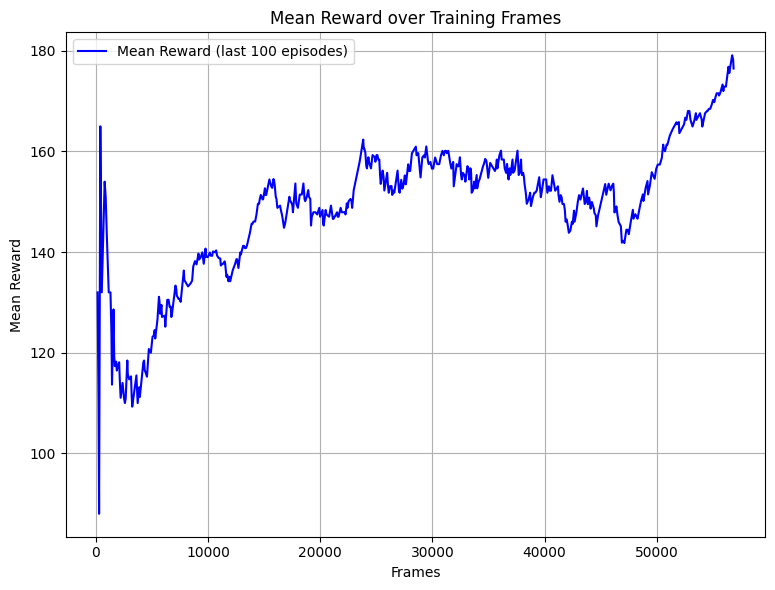

Learning curves for mean reward and loss plotted successfully.


In [20]:
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

def get_latest_event_file(log_dir):
    list_of_files = glob(os.path.join(log_dir, '**', 'events.out.tfevents.*'), recursive=True)
    if not list_of_files:
        return None
    latest_file = max(list_of_files, key=os.path.getmtime)
    return latest_file

latest_event_file = get_latest_event_file(log_dir)

if latest_event_file:
    event_acc = EventAccumulator(latest_event_file)
    event_acc.Reload()

    # Extract scalar data
    rewards = []
    losses = []
    frames = []
    loss_frames = []

    if 'reward_100' in event_acc.Tags()['scalars']:
        for s in event_acc.Scalars('reward_100'):
            rewards.append(s.value)
            frames.append(s.step)
    else:
        print("Warning: 'reward_100' not found in scalars. Available tags:", event_acc.Tags()['scalars'])

    if 'loss_t' in event_acc.Tags()['scalars']:
        for s in event_acc.Scalars('loss_t'):
            losses.append(s.value)
            loss_frames.append(s.step)
    else:
        print("Warning: 'loss_t' not found in scalars. Available tags:", event_acc.Tags()['scalars'])

    # Create DataFrames for easier plotting
    df_rewards = pd.DataFrame({'frame_idx': frames, 'mean_reward': rewards})

    # Plotting
    plt.figure(figsize=(15, 6))

    if not df_rewards.empty:
        plt.subplot(1, 2, 1)
        plt.plot(df_rewards['frame_idx'], df_rewards['mean_reward'], label='Mean Reward (last 100 episodes)', color='blue')
        plt.xlabel('Frames')
        plt.ylabel('Mean Reward')
        plt.title('Mean Reward over Training Frames')
        plt.grid(True)
        plt.legend()
    else:
        print("No reward data to plot.")

    if losses:
        df_losses = pd.DataFrame({'frame_idx': loss_frames, 'loss': losses})
        plt.subplot(1, 2, 2)
        plt.plot(df_losses['frame_idx'], df_losses['loss'], label='Loss', color='red')
        plt.xlabel('Frames')
        plt.ylabel('Loss')
        plt.title('Loss over Training Frames')
        plt.grid(True)
        plt.legend()
    else:
        print("No loss data to plot.")

    plt.tight_layout()
    plt.show()

    print("Learning curves for mean reward and loss plotted successfully.")
else:
    print("No TensorBoard event files found in the 'runs' directory.")
